In [13]:
from sktime.datasets import load_airline
from sktime.forecasting.fbprophet import Prophet

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import ETS
from orbit.diagnostics.plot import plot_predicted_data

In [39]:
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

## Data

The *iclaims* data contains the weekly initial claims for US unemployment (obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA)) benefits against a few related Google trend queries (unemploy, filling and job) from Jan 2010 - June 2018. This aims to demo a similar dataset from the Bayesian Structural Time Series (BSTS) model [(Scott and Varian 2014)](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf).

Note that the numbers are log-log transformed for fitting purpose and the discussion of **using the regressors** can be found in later chapters with the **Damped Local Trend (DLT)** model.

In [7]:
# load data
df = load_iclaims()
date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [8]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


Train-test split.

In [9]:
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

In [37]:
df_prophet = df.copy()
df_prophet = df_prophet.set_index('week', drop=True)
df_prophet.index = df_prophet.index.to_period('W-MON').to_timestamp()
train_df_prophet = df_prophet[:-test_size]
test_df_prophet = df_prophet[-test_size:]

In [52]:

# Prophet requires to have data with a pandas.DatetimeIndex
y = train_df_prophet.claims
forecaster = Prophet(
    seasonality_mode='multiplicative',
#     growth="logistic",
    n_changepoints=int(len(y) / 12),
    add_country_holidays={'country_name': 'US'},
    yearly_seasonality=True)
forecaster.fit(y)

y_pred = forecaster.predict(fh=list(range(1, 62)))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/the_sun/.local/lib/python3.8/site-packages/sktime/forecasting/base/_fh.py:337: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  cutoff = _coerce_to_period(cutoff, freq=cutoff.freqstr)


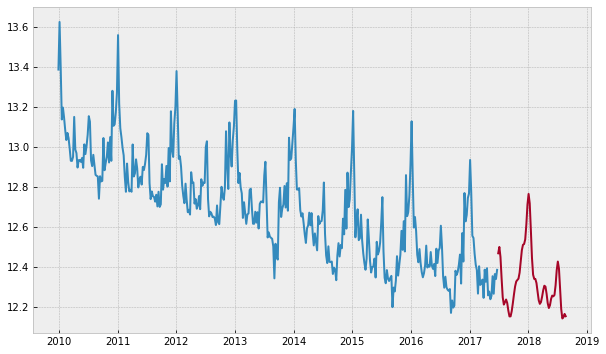

In [53]:
fig = plt.figure(figsize=[10, 6])
plt.plot(y)
plt.plot(y_pred)

# Quick Start

This session covers topics:

- a forecast task on iclaims dataset
- a simple Bayesian ETS Model using `PyStan`
- posterior distribution extraction
- tools to visualize the forecast

## Forecasting Using Orbit

`Orbit` aims to provide an intuitive **initialize-fit-predict** interface for working with forecasting tasks. Under the hood, it utilizes probabilistic modeling API such as
`PyStan` and `Pyro`. We first illustrate a Bayesian implementation of Rob Hyndman's ETS (which stands for Error, Trend, and Seasonality) Model [(Hyndman et. al, 2008)](http://www.exponentialsmoothing.net/home) using `PyStan`.

In [6]:
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [1]:
%%time
ets.fit(df=train_df)

In [8]:
predicted_df = ets.predict(df=test_df)

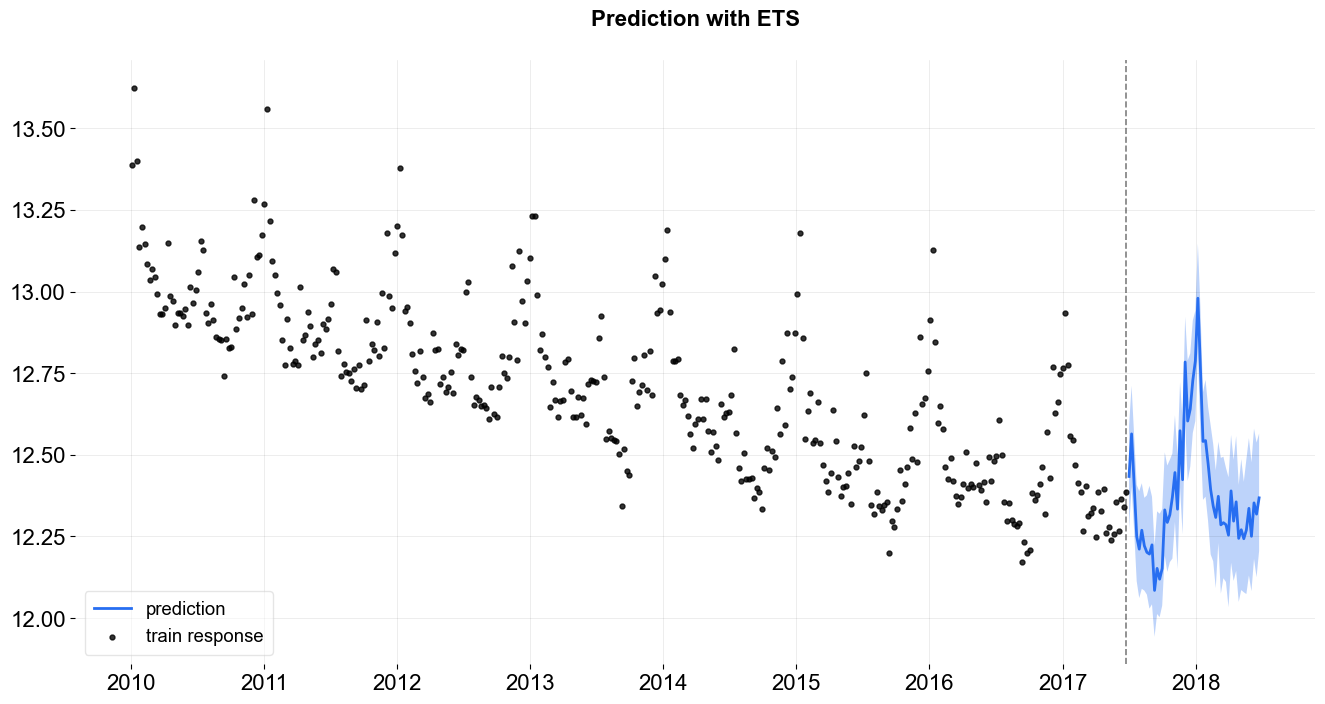

In [9]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETS')

## Extract and Analyze Posterior Samples

Users can use `.get_posterior_samples()` to extract posterior samples in an `OrderedDict` format.

In [10]:
posterior_samples = ets.get_posterior_samples()
posterior_samples.keys()

odict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

The extracted parameters posteriors are pretty much compatible diagnostic with [arviz](https://github.com/arviz-devs/arviz). To do that, users can set `permute=False` to preserve chain information.

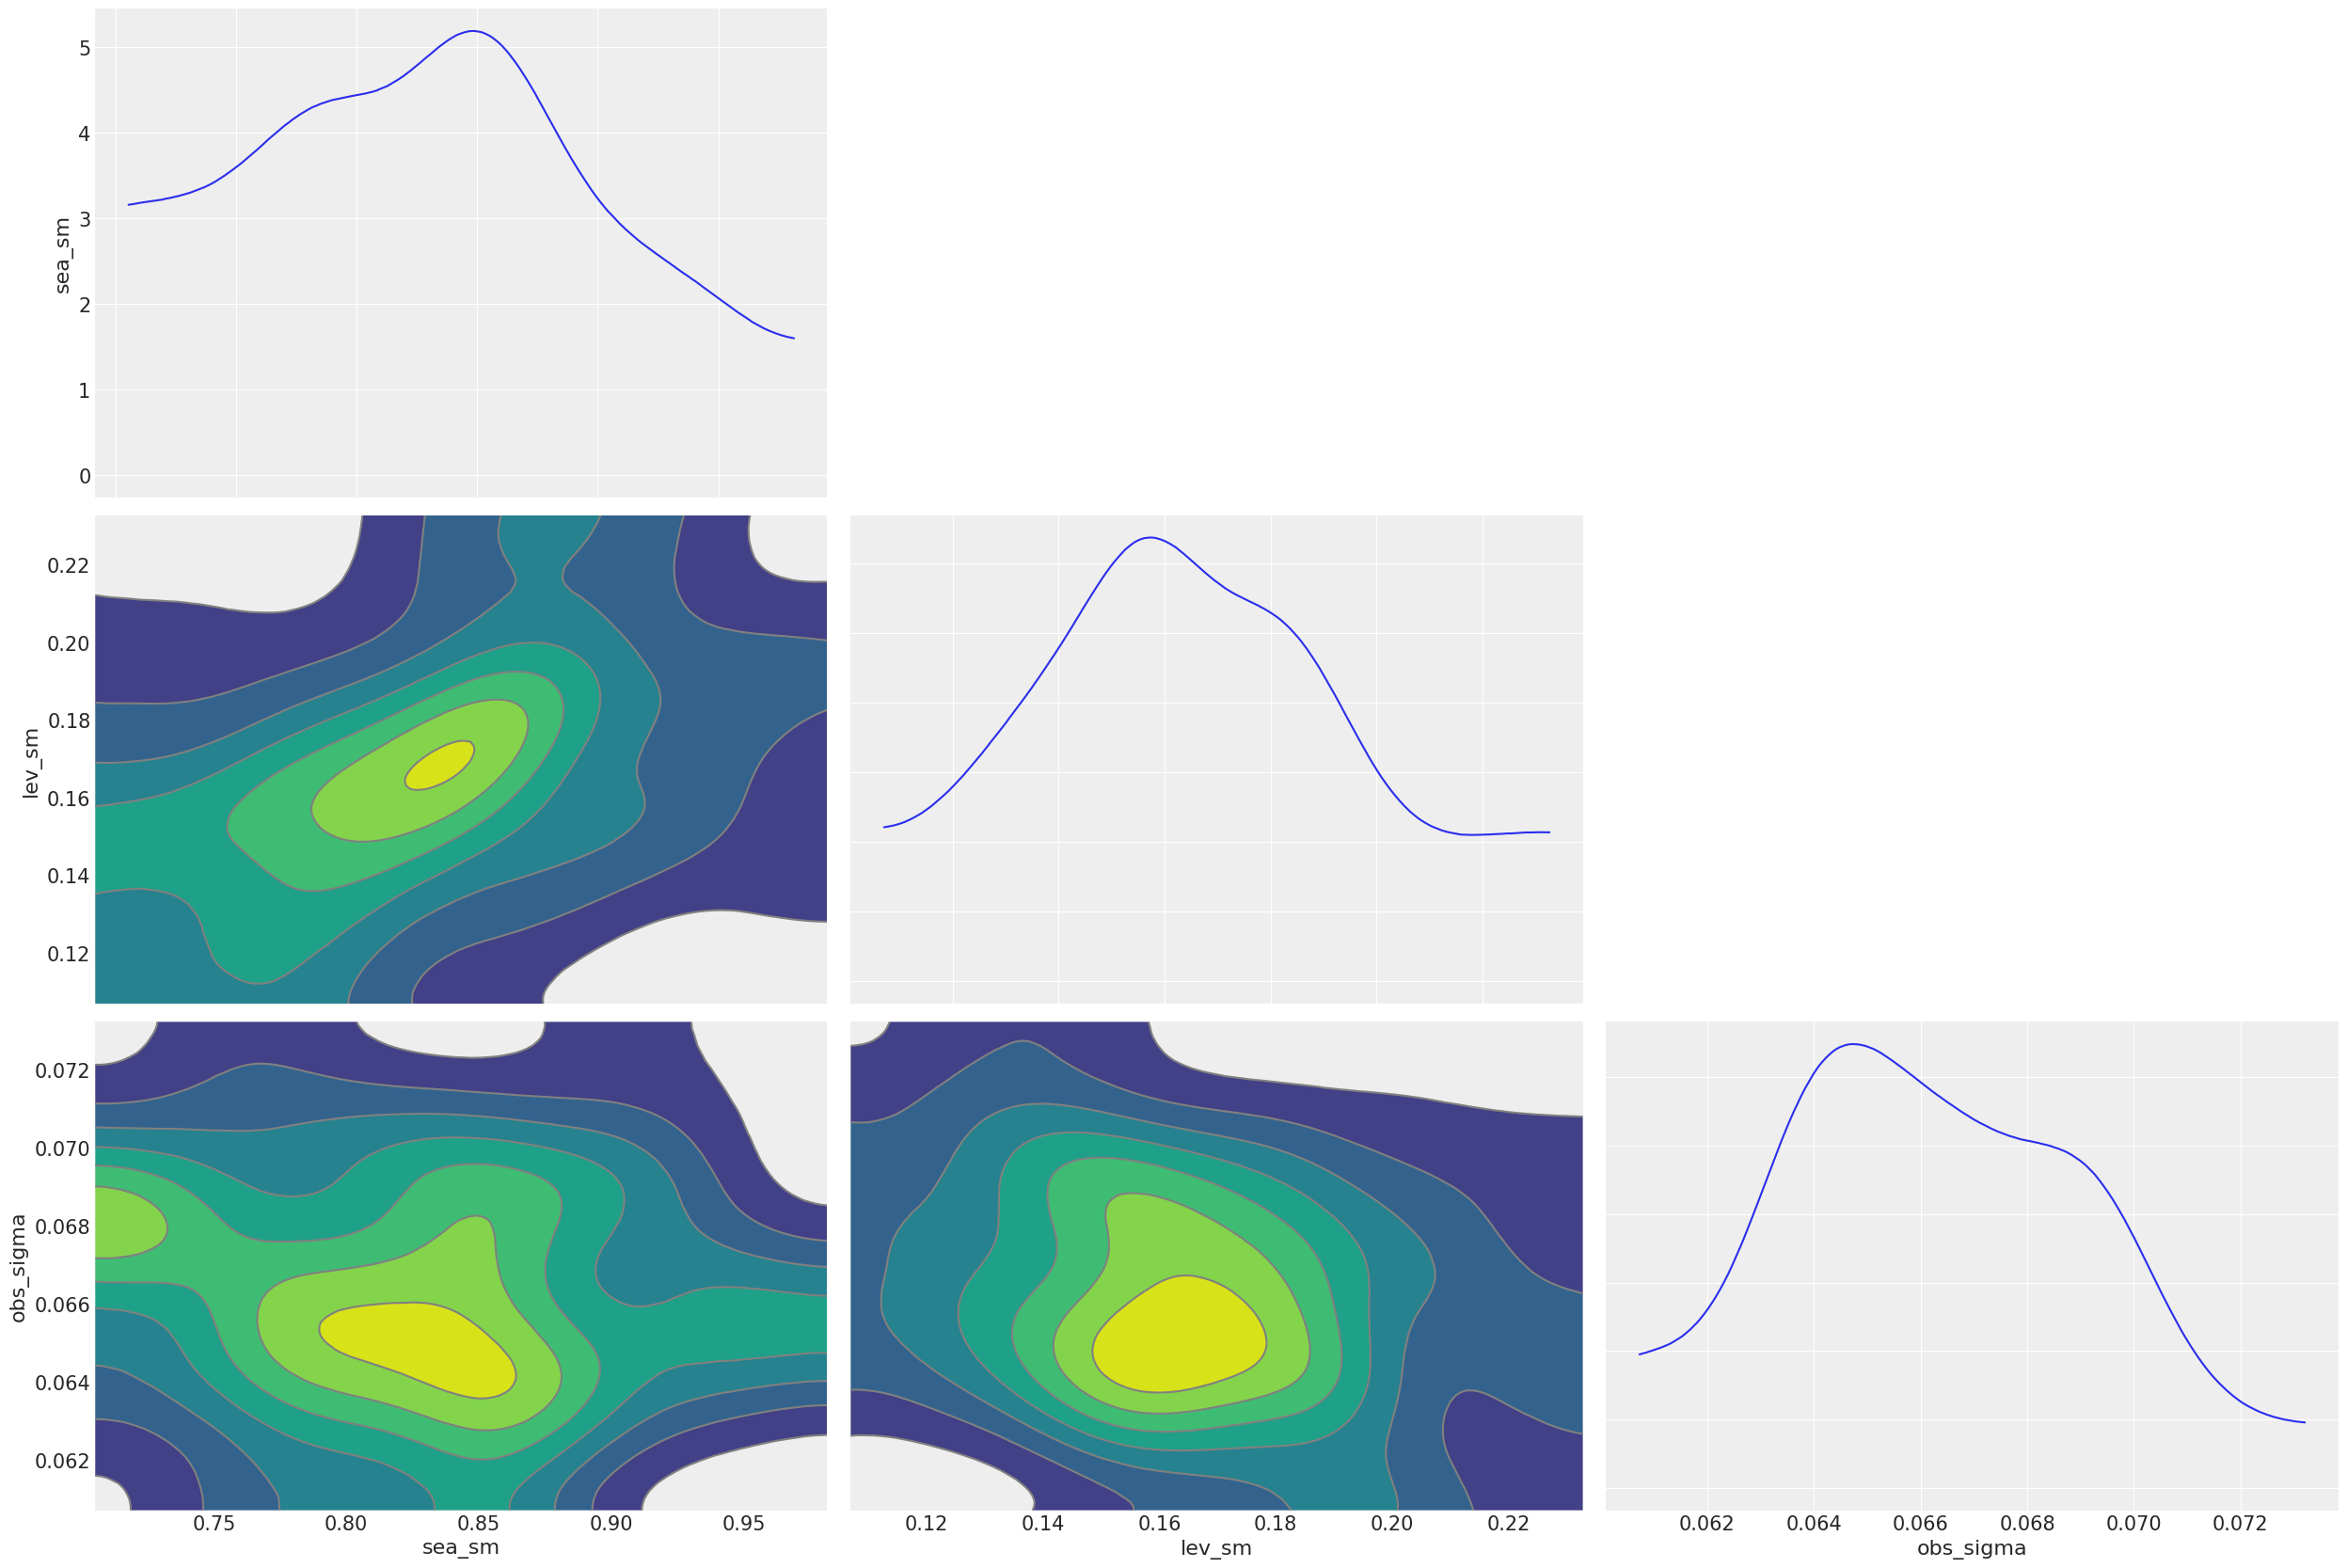

In [11]:
import arviz as az

posterior_samples = ets.get_posterior_samples(permute=False)

# example from https://arviz-devs.github.io/arviz/index.html
az.style.use("arviz-darkgrid")
az.plot_pair(
    posterior_samples,
    var_names=["sea_sm", "lev_sm", "obs_sigma"],
    kind="kde",
    marginals=True,
    textsize=15,
)
plt.show()

# Methods of Estimations and Predictions

There are three methods supported in `Orbit` model parameters estimation (a.k.a posteriors in Bayesian).

1. Maximum a Posteriori (MAP)
2. Markov Chain Monte Carlo (MCMC)
3. Stochastic Variational Inference (SVI)

This session will cover the first two: **MAP** and **MCMC** which mainly uses [PyStan2.0](https://pystan2.readthedocs.io/en/latest/) at the back end. Users can simply can leverage the args `estimator` to pick the method (`stan-map` and `stan-mcmc`). The details will be covered by the sections below. The SVI method is calling [Pyro](https://pyro.ai/) by specifying `estimator='pyro-svi'`. However, it is covered by a separate session.

## Maximum a Posteriori (MAP)

To use MAP method, one can simply specify `estimator='stan-map'` when instantiating a model. The advantage of MAP estimation is a faster computational speed. In MAP, the uncertainty is mainly generated the noise process with bootstrapping. However, the uncertainty would not cover parameters variance as well as the credible interval from seasonality or other components.

In [4]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
)
ets.fit(df=train_df) 
predicted_df = ets.predict(df=test_df)

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


CPU times: user 35.3 ms, sys: 8.29 ms, total: 43.6 ms
Wall time: 250 ms


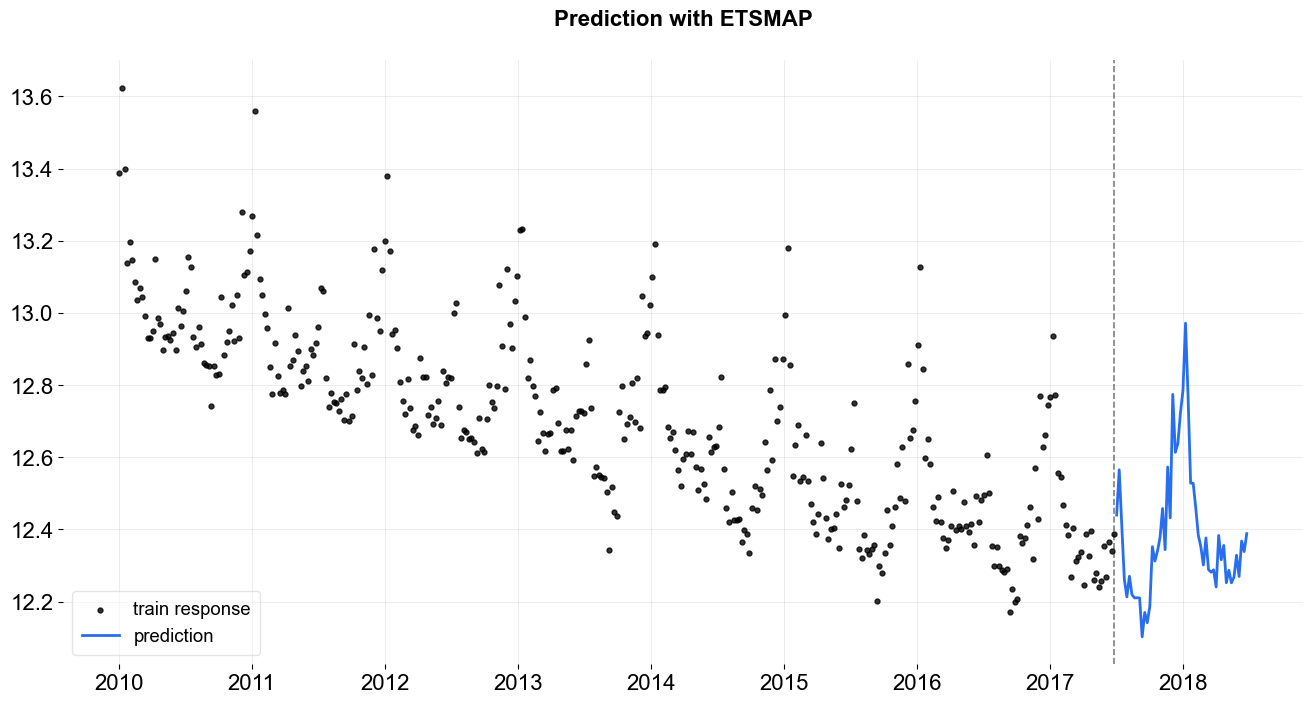

In [5]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETSMAP')

To have the uncertainty from MAP, one can speicify `n_bootstrap_draws`.  The default is set to be `-1` which mutes the bootstrap process. Users can also specify a particular percentiles to report prediction intervals by passing list of percentiles with args `prediction_percentiles`.

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


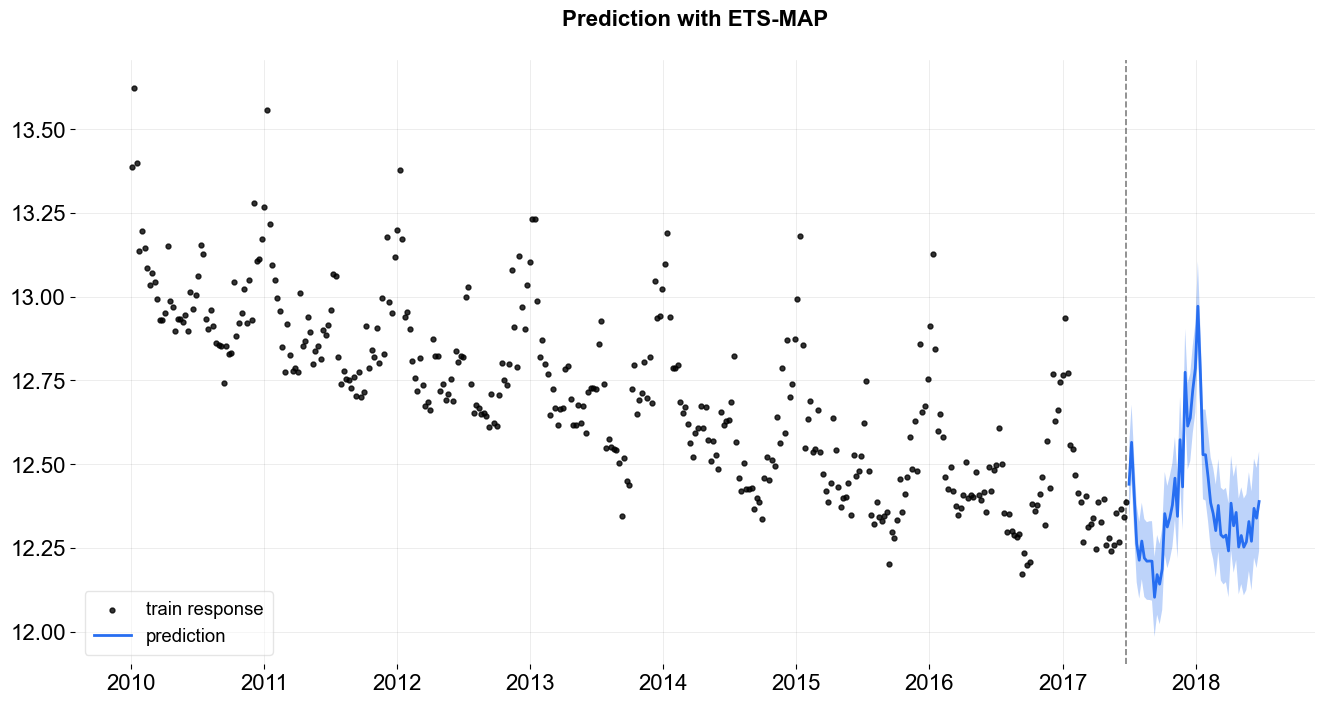

In [6]:
# default: [10, 90]
prediction_percentiles=[10, 90]
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    n_bootstrap_draws=1e4,
    prediction_percentiles=prediction_percentiles, 
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, 
                        prediction_percentiles=prediction_percentiles,
                        title='Prediction with ETS-MAP')

One can access the posterior estimated by calling the `.get_point_posteriors()`. The outcome from this function is a `dict` of `dict` where the top layer stores the type of point estimate while the second layer stores the parameters labels and values.

In [7]:
pt_posteriors = ets.get_point_posteriors()['map']
pt_posteriors.keys()

dict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

In general, the first dimension is just `1` as a point estimate for each parameter. The rest of the dimension will depend on the dimension of parameter itself.

In [8]:
lev = pt_posteriors['l']
lev.shape

(1, 391)

## MCMC

To use MCMC method, one can specify `estimator='stan-mcmc'` (the default) when instantiating a model.  Compared to MAP, it usually takes longer time to fit. As the model now fitted as a **full Bayesian** model where **No-U-Turn Sampler (NUTS)** [(Hoffman and Gelman 2011)](https://arxiv.org/abs/1111.4246) is carried out under the hood. By default, a full sampling on posteriors distribution is conducted. Hence, full distribution of the predictions are always provided. 

### MCMC - Full Bayesian Sampling

In [9]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
    num_warmup=400,
    num_sample=400,
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 100 and samples(per chain): 100.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 80.1 ms, sys: 66.5 ms, total: 147 ms
Wall time: 838 ms


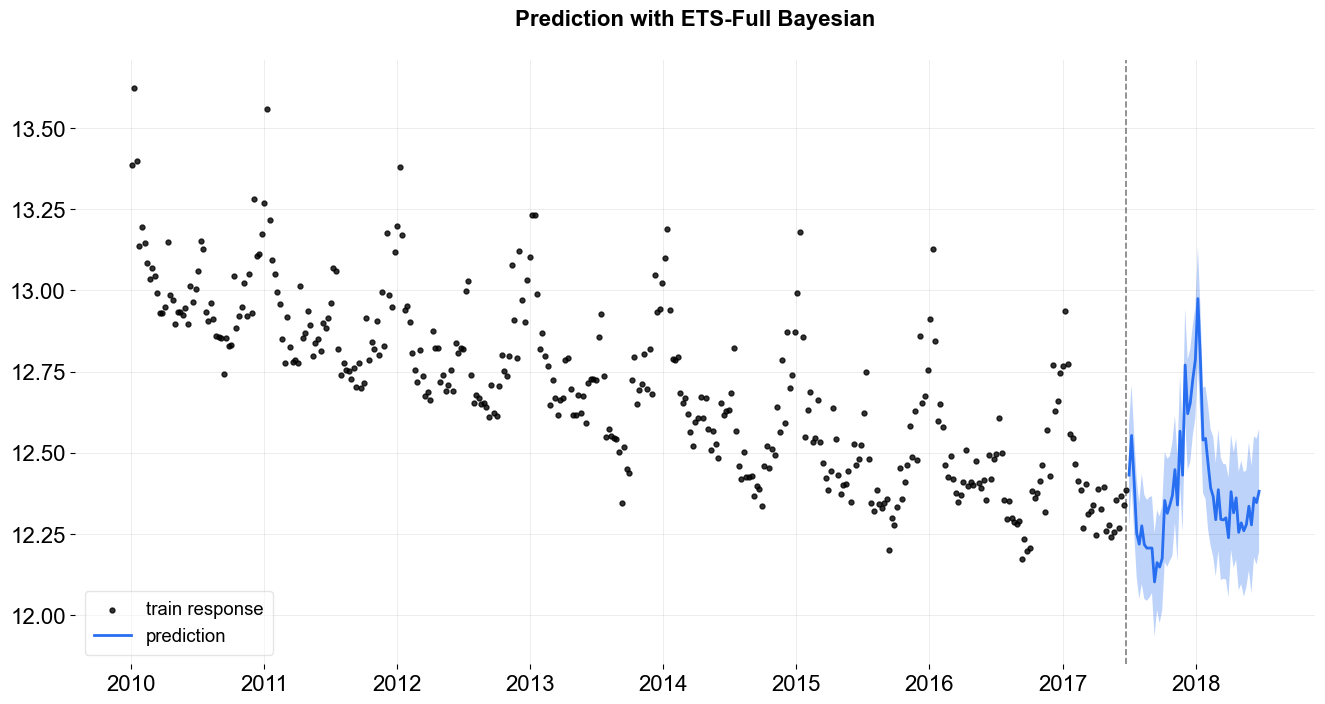

In [10]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETS-Full Bayesian')

Also, users can request prediction with credible intervals of each component.

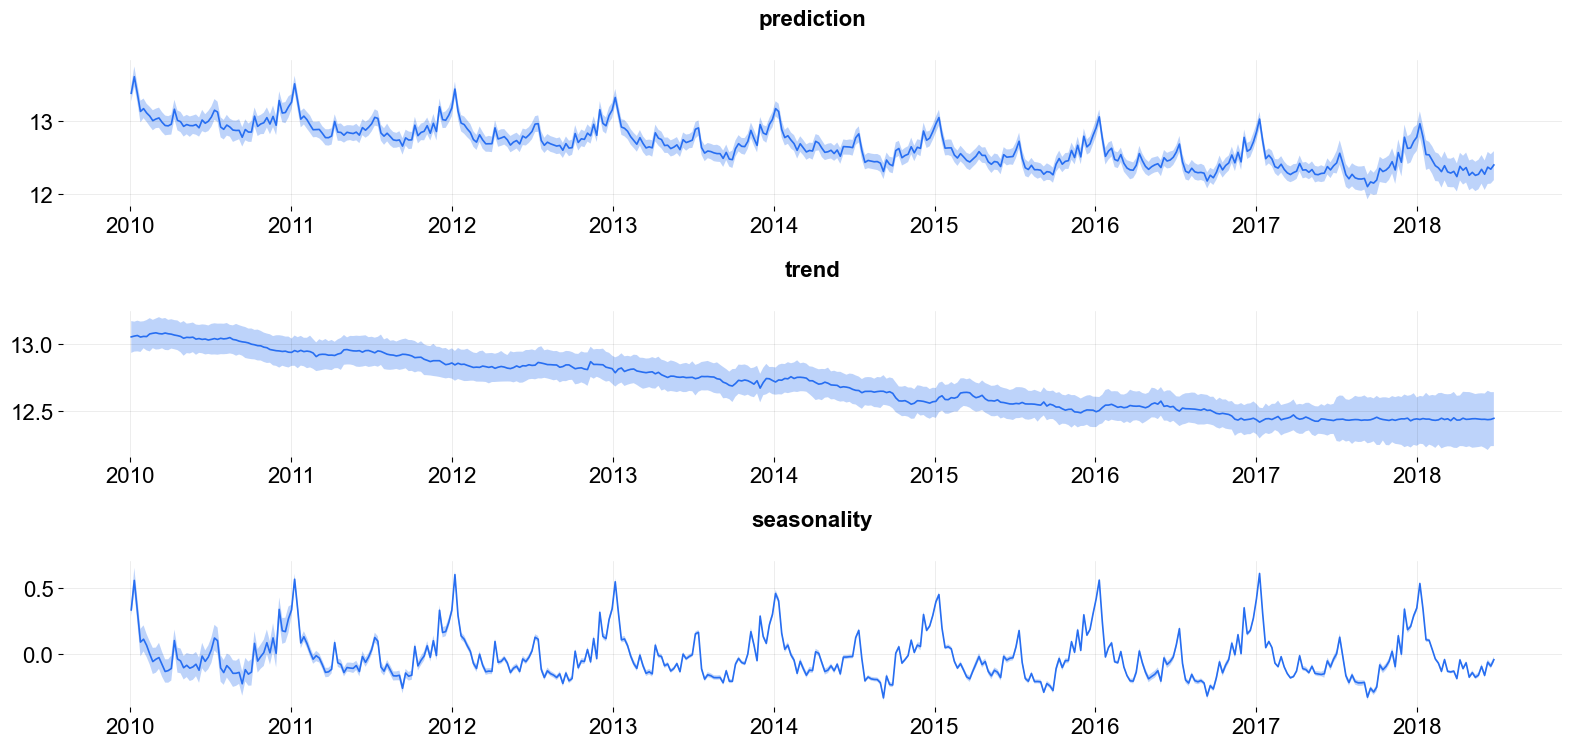

array([<AxesSubplot:title={'center':'prediction'}>,
       <AxesSubplot:title={'center':'trend'}>,
       <AxesSubplot:title={'center':'seasonality'}>], dtype=object)

In [11]:
predicted_df = ets.predict(df=df, decompose=True)
plot_predicted_components(predicted_df, date_col=date_col, 
                          plot_components=['prediction', 'trend', 'seasonality'])

Just like the `MAPForecaster`, one can also access the posterior samples by calling the function `.get_posterior_samples()`.

In [12]:
posterior_samples = ets.get_posterior_samples()
posterior_samples.keys()

odict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

As mentioned, in **MCMC**  (**Full Bayesian**) models, the first dimension reflects the sample size. 

In [13]:
lev = posterior_samples['l']
lev.shape

(400, 391)

### MCMC - Point Estimation

Users can also choose to derive point estimates via MCMC by specifying `point_method` as `mean` or `median` via the call of `.fit`. In that case, posteriors samples are first aggregated by mean or median and store as a point estimate for final prediction. Just like other point estimate, users can specify `n_bootstrap_draws` to report uncertainties.


In [14]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
    n_bootstrap_draws=1e4,
)

# specify point_method e.g. 'mean', 'median'
ets.fit(df=train_df, point_method='mean')
predicted_df = ets.predict(df=test_df)

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 356 ms, sys: 150 ms, total: 507 ms
Wall time: 1.34 s


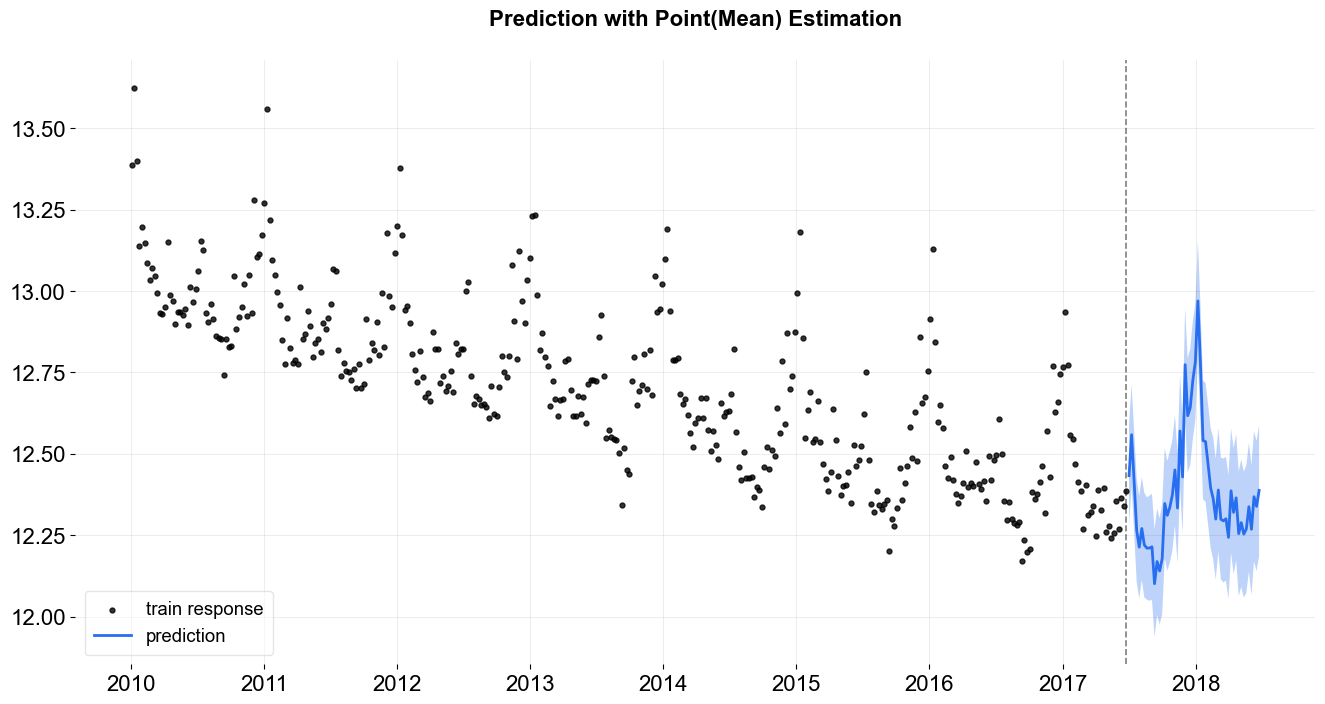

In [15]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, 
                        title='Prediction with Point(Mean) Estimation')

One can always access the the point estimated posteriors by `.get_point_posteriors()` (including the cases fitting the parameters through MCMC).

In [16]:
ets.get_point_posteriors()['mean'].keys()

dict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

In [17]:
ets.get_point_posteriors()['median'].keys()

dict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

# Randomness Control and Reproducible Results 

There are randomness involved in the random initialization, sampling and bootstrapping process. Some of them with sufficient condition such as converging status and large amount of samples, can be fixed even without a fixed seed.  However, they are not guaranteed. Two settings needed to allow fully reproducible results and will be demoed from this session:

1. fix the seed on fitting
2. fix the seed on prediction

## Fixing Seed in Fitting

By default, the seed supplied during the **initialization** step is fixed. This allows fully reproducible posteriors samples by default. For other purpose, users can randomize the seed. Nonetheless, this process usually assumes stable result with or without a fixed seed. Otherwise, convergence alert should be raised.

With different seeds, results should be closed but not identical:

In [4]:
dlt1 = DLT(response_col='claims', date_col='week', seed=2021, estimator='stan-map', n_bootstrap_draws=1e3)
dlt2 = DLT(response_col='claims', date_col='week', seed=2020, estimator='stan-map', n_bootstrap_draws=1e3)

dlt1.fit(df);
dlt2.fit(df);

lev1 = dlt1.get_point_posteriors()['map']['l']
lev2 = dlt2.get_point_posteriors()['map']['l']

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


In [5]:
np.all(lev1 == lev2)

False

In [6]:
np.allclose(lev1, lev2, rtol=1e-3)

True

With fixed seeds, results should be identical:

In [7]:
dlt1 = DLT(response_col='claims', date_col='week', seed=2020, estimator='stan-map', n_bootstrap_draws=1e3)
dlt2 = DLT(response_col='claims', date_col='week', seed=2020, estimator='stan-map', n_bootstrap_draws=1e3)

dlt1.fit(df);
dlt2.fit(df);

lev1 = dlt1.get_point_posteriors()['map']['l']
lev2 = dlt2.get_point_posteriors()['map']['l']

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


In [8]:
np.all(lev1 == lev2)

True

In sampling algorithm, users should expect identical posteriors with fixed seed:

In [9]:
dlt_mcmc1 = DLT(response_col='claims', date_col='week', seed=2020, estimator='stan-mcmc')
dlt_mcmc2 = DLT(response_col='claims', date_col='week', seed=2020, estimator='stan-mcmc')

dlt_mcmc1.fit(df);
dlt_mcmc2.fit(df);

lev_mcmc1 = dlt_mcmc1.get_posterior_samples()['l']
lev_mcmc2 = dlt_mcmc2.get_posterior_samples()['l']

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
print(lev_mcmc1.shape)
print(lev_mcmc2.shape)
np.all(lev1 == lev2)

(100, 443)
(100, 443)


True

## Fixing Seed in Prediction

Unlike the fitting process, the seed in prediction is set to be random by default unless users provided a fixed seed. Once a fixed seed provided through the args in `.predict()`. Users should expect identical result.

In [11]:
# check with MAP estimator
pred1 = dlt1.predict(df, seed=2020)['prediction'].values
pred2 = dlt2.predict(df, seed=2020)['prediction'].values
np.all(pred1 == pred2)

True

In [12]:
# check with MCMC estimator
pred1 = dlt_mcmc1.predict(df, seed=2020)['prediction'].values
pred2 = dlt_mcmc2.predict(df, seed=2020)['prediction'].values
np.all(pred1 == pred2)

True

# Damped Local Trend (DLT)

This section covers topics including:

- DLT model structure
- DLT global trend configurations
- Adding regressors in DLT
- Other configurations

## Model Structure

**DLT** is one of the main exponential smoothing models we support in `orbit`.  Performance is benchmarked with M3 monthly, M4 weekly dataset and some Uber internal dataset [(Ng and Wang et al., 2020)](https://arxiv.org/abs/2004.08492).  The model is a fusion between the classical ETS [(Hyndman et. al., 2008)](http://www.exponentialsmoothing.net/home)) with some refinement leveraging ideas from Rlgt [(Smyl et al., 2019)](https://cran.r-project.org/web/packages/Rlgt/index.html). The model has a structural forecast equations

$$
\begin{align*}
y_t &=\mu_t + s_t + r_t +  \epsilon_t \\
\mu_t &=g_t + l_{t-1} +  \theta{b_{t-1}} \\
\epsilon_t  &~\sim \mathtt{Student}(\nu, 0, \sigma)\\
\sigma &~\sim  \mathtt{HalfCauchy}(0, \gamma_0)
\end{align*}
$$

with the update process

$$
\begin{align*}
g_t &= D(t)\\
l_t &= \rho_l(y_t - g_{t} - s_t - r_t) + (1-\rho_l)(l_{t-1} + \theta b_{t-1})\\
b_t &=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)\theta b_{t-1}\\
s_{t+m} &=  \rho_s(y_t - l_t - r_t) + (1-\rho_s)s_t\\
r_t &=  \Sigma_{j}\beta_j x_{jt}
\end{align*}
$$

One important point is that using $y_t$ as a log-transformed response usually yield better result, especially we can interpret such log-transformed model as a *multiplicative form* of the original model.  Besides, there are two new additional components compared to the classical damped ETS model:

1. $D(t)$ as the deterministic trend process
2. $r$ as the regression component with $x$ as the regressors

<div class="alert alert-info">

<font size="+2">Note</font>

Just like LGT model, we also provide MAP and MCMC (full Bayesian) methods for DLT model (by specifying `estimator='stan-map'` or `estimator='stan-mcmc'` when instantiating a model). 
    
MCMC is usually more robust but may take longer time to train. In this notebook, we will use the MAP method for illustration purpose.

        
</div>

## Global Trend Configurations

There are a few choices of $D(t)$ configured by `global_trend_option`:

1. `linear` (default)
2. `loglinear`
3. `flat`
4. `logistic`    

Mathematically, they are expressed as such,

**1. Linear**: 

$D(t) = \delta_{\text{intercept}} + \delta_{\text{slope}} \cdot t$ 

**2. Log-linear**:

$D(t) = \delta_{\text{intercept}} + ln(\delta_{\text{slope}} \cdot t)$ 

**3. Logistic**:

$D(t) = L + \frac{U - L} {1 + e^{- \delta_{\text{slope}} \cdot t}}$ 

**4. Flat**:

$D(t) = \delta_{\text{intercept}}$ 

where $\delta_{\text{intercept}}$ and $\delta_{\text{slope}}$ are fitted parameters and $t$ is rescaled time-step between $0$ and $T$ (=number of time steps).

To show the difference among these options, their predictions are projected in the charts below. Note that the default is set to `linear` which is also used in the benchmarking process mentioned previously. During prediction, a convenient function `make_future_df()` is called to generate future data frame (ONLY applied when you don't have any regressors!).

### linear global trend

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


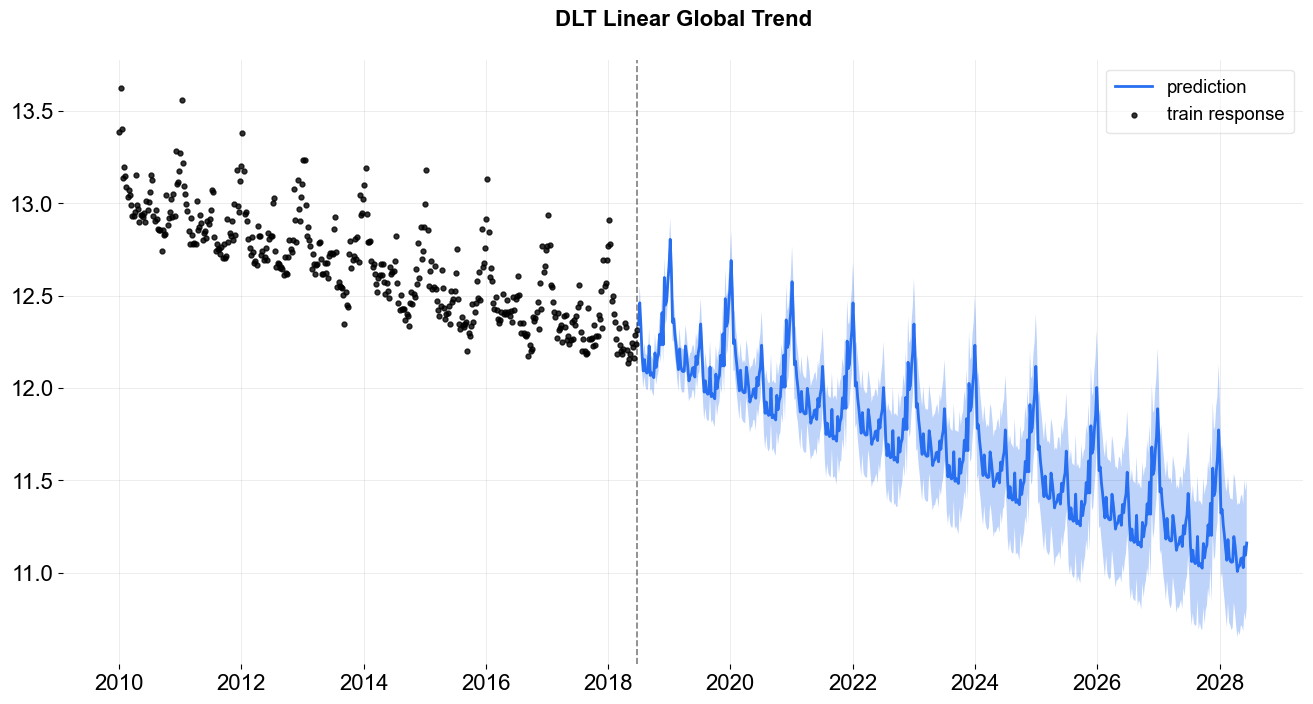

CPU times: user 1.03 s, sys: 142 ms, total: 1.17 s
Wall time: 1.03 s


In [4]:
%%time

dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    global_trend_option='linear',
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

dlt.fit(df)
test_df = dlt.make_future_df(periods=52 * 10)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(df, predicted_df, date_col, response_col,  title='DLT Linear Global Trend')

One can use `.get_posterior_samples()` to extract the samples for all sampling parameters.

In [5]:
dlt.get_posterior_samples().keys()

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl'])

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


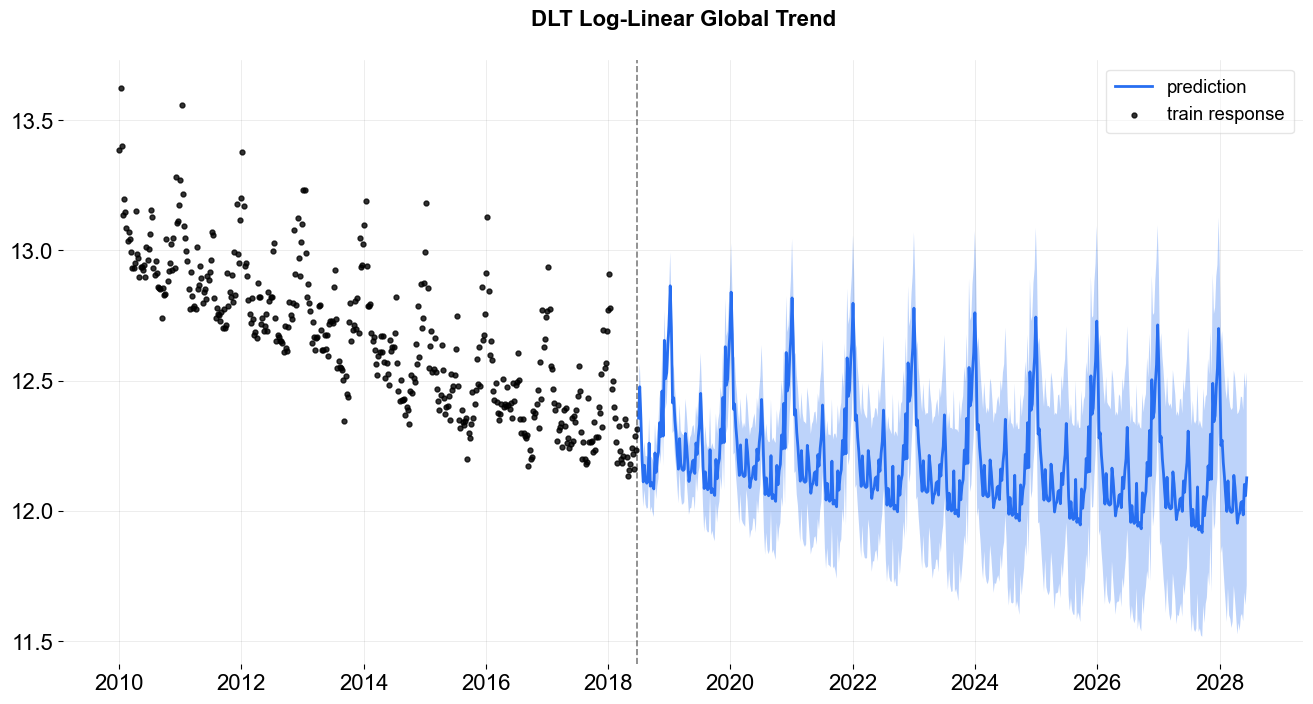

CPU times: user 1.04 s, sys: 107 ms, total: 1.15 s
Wall time: 915 ms


In [6]:
%%time
# log-linear global trend
dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    estimator='stan-map',
    seed=8888,
    global_trend_option='loglinear',
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

dlt.fit(df)
# re-use the test_df generated above
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(df, predicted_df, date_col, response_col,  title='DLT Log-Linear Global Trend')

In logistic trend, users need to specify the args `global_floor` and `global_cap`. These args are with default `0` and `1`.

### logistic global trend

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


CPU times: user 715 ms, sys: 59.8 ms, total: 775 ms
Wall time: 737 ms


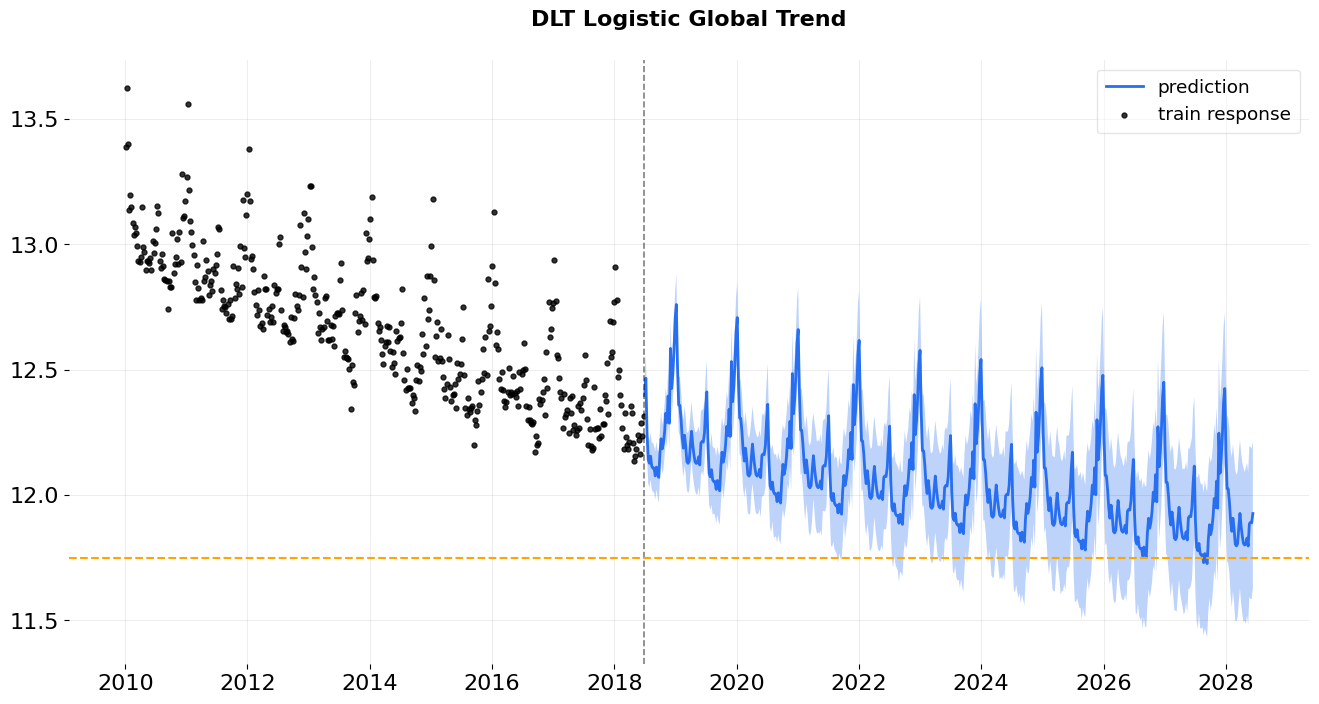

In [7]:
%%time

dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    global_trend_option='logistic',
    global_cap=9999,
    global_floor=11.75,
    damped_factor=0.1,
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

dlt.fit(df)
predicted_df = dlt.predict(test_df)
ax = plot_predicted_data(df, predicted_df, date_col, response_col, 
                         title='DLT Logistic Global Trend', is_visible=False);
ax.axhline(y=11.75, linestyle='--', color='orange')
ax.figure

Note: Theoretically, the trend is bounded by the `global_floor` and `global_cap`. However, because of seasonality and regression, the predictions can still be slightly lower than the floor or higher than the cap.

### flat trend

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


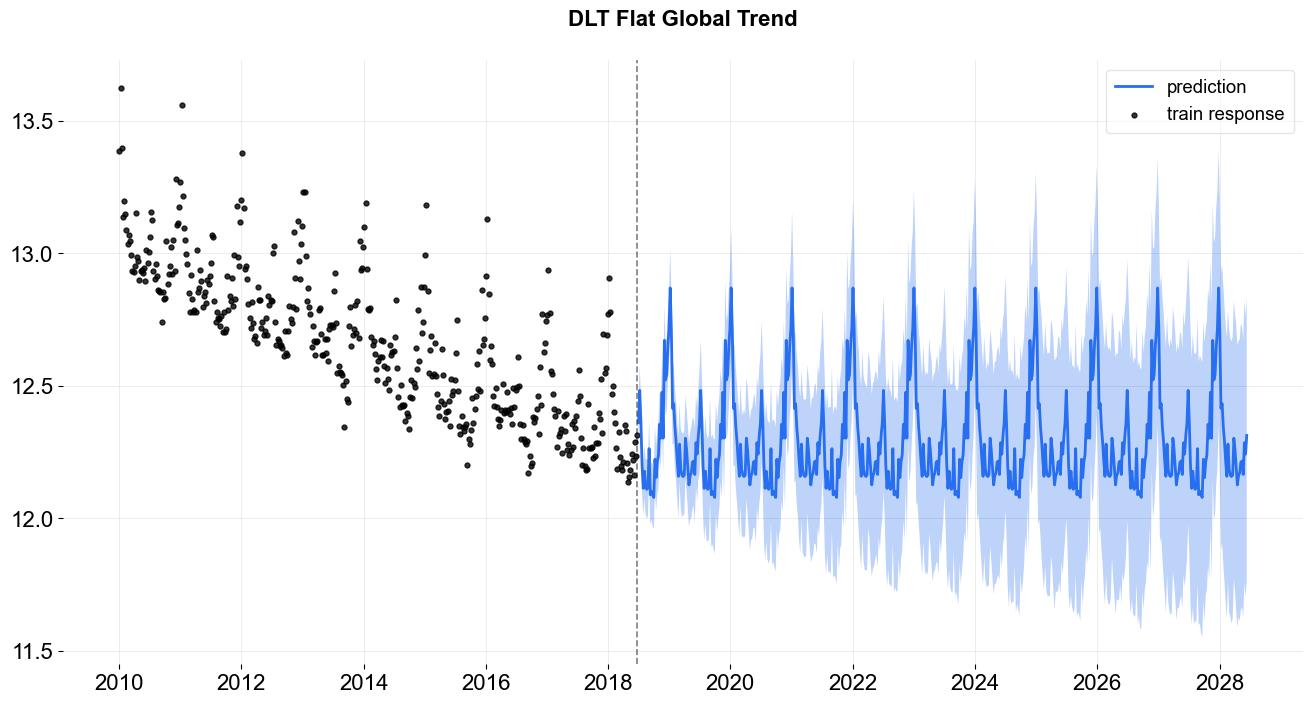

CPU times: user 1.01 s, sys: 101 ms, total: 1.11 s
Wall time: 883 ms


In [8]:
%%time

dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    global_trend_option='flat',
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

dlt.fit(df)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(df, predicted_df, date_col, response_col,  title='DLT Flat Global Trend')

## Regression

You can also add regressors into the model by specifying `regressor_col`. This serves the purpose of nowcasting or forecasting when exogenous regressors are known such as events and holidays. Without losing generality, the interface is set to be

$$\beta_j ~\sim \mathcal{N}(\mu_j, \sigma_j^2)$$

where $\mu_j = 0$  and $\sigma_j = 1$ by default as a non-informative prior. These two parameters are set by the arguments `regressor_beta_prior` and `regressor_sigma_prior` as a list.  For example,

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


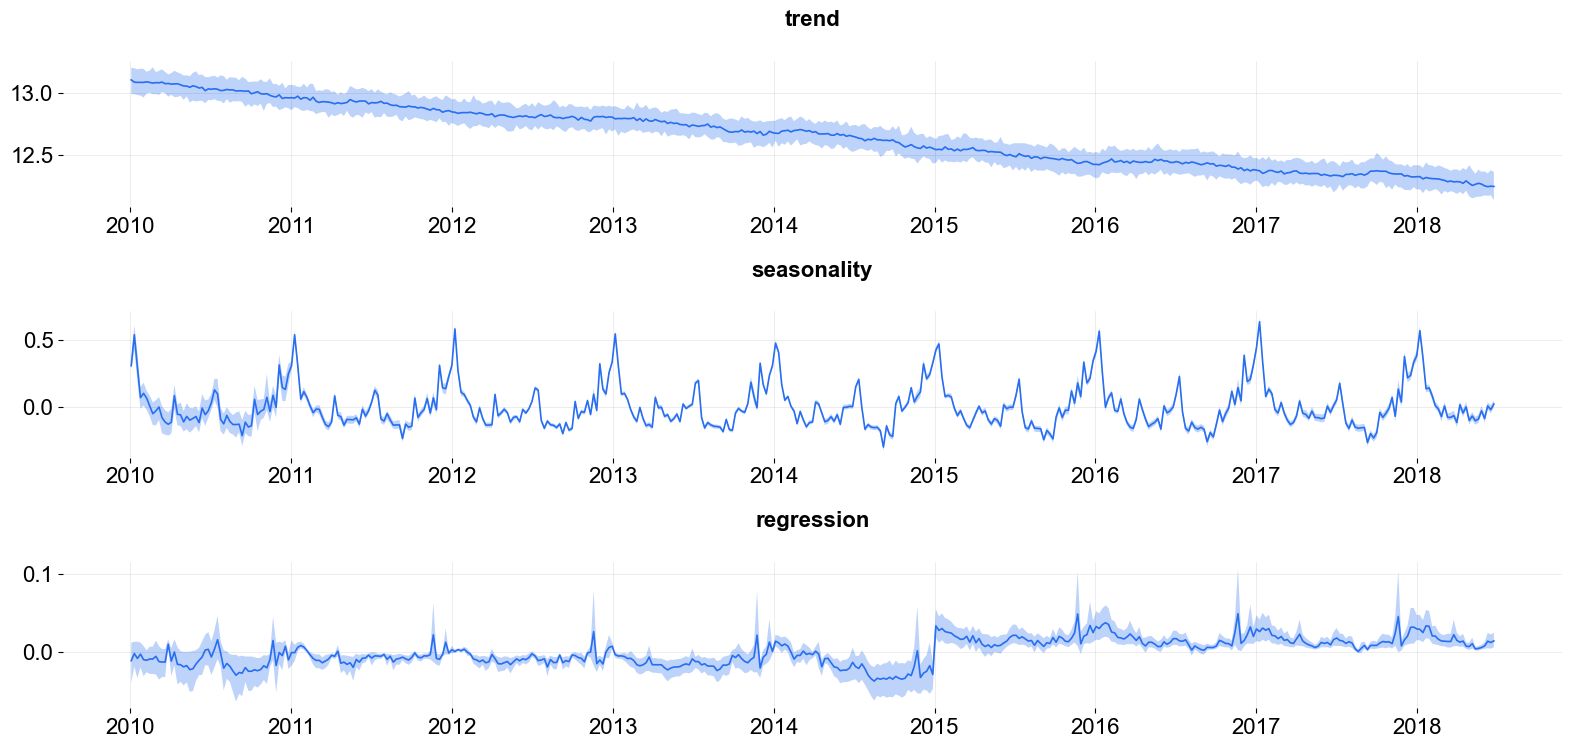

In [9]:
dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seed=8888,
    seasonality=52,
    regressor_col=['trend.unemploy', 'trend.filling'],
    regressor_beta_prior=[0.1, 0.3],
    regressor_sigma_prior=[0.5, 2.0],
)

dlt.fit(df)
predicted_df = dlt.predict(df, decompose=True)
plot_predicted_components(predicted_df, date_col);

One can also use `.get_regression_coefs` to extract the regression coefficients along with the confidence interval when posterior samples are available. The default lower and upper limits are set to be .05 and .95.

In [10]:
dlt.get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,trend.unemploy,Regular,0.048654,0.024427,0.080138,1.00,0.00
1,trend.filling,Regular,0.069065,-0.002541,0.159119,0.92,0.08


There are much more configurations on regression such as the regressors sign and penalty type.  They will be discussed in subsequent sections.

### High Dimensional and  Fourier Series Regression

In case of high dimensional regression, users can consider fixing the smoothness with a relatively small levels smoothing values e.g. setting `level_sm_input=0.01`. This is particularly useful in modeling higher frequency time-series such as daily and hourly data using regression on Fourier series. Check out the `examples/` folder for more details.

# Local Global Trend (LGT)

In this section, we will cover:

- LGT model structure
- difference between DLT and LGT
- syntax to call LGT classes with different estimation methods

**LGT** stands for Local and Global Trend and is a refined model from **Rlgt** [(Smyl et al., 2019)](https://cran.r-project.org/web/packages/Rlgt/index.html).  The main difference is that LGT is an additive form taking log-transformation response as the modeling response.  This essentially converts the model into a multiplicative with some advantages [(Ng and Wang et al., 2020)](https://arxiv.org/abs/2004.08492).  **However, one drawback of this approach is that negative response values are not allowed due to the existence of the global trend term and because of that we start to deprecate the support of regression of this model.**

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import orbit
from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

In [2]:
print(orbit.__version__)

1.1.2


## Model Structure

$$
\begin{align*}
 y_{t}  &= \mu_t + s_t   + \epsilon_t \\
\mu_t &= l_{t-1} + \xi_1 b_{t-1} + \xi_2 l_{t-1}^{\lambda}\\
\epsilon_t  &~\sim \mathtt{Student}(\nu, 0, \sigma)\\
\sigma &~\sim  \mathtt{HalfCauchy}(0, \gamma_0)
\end{align*}
$$

with the update process,

$$
\begin{align*}
l_t &= \rho_l(y_t - s_t) + (1-\rho_l)l_{t-1}\\
b_t &=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)b_{t-1}\\
s_{t+m} &=  \rho_s(y_t - l_t ) + (1-\rho_s)s_t
\end{align*}
$$

Unlike **DLT** model which has a deterministic trend, **LGT** introduces a hybrid trend where it consists of 

- local trend takes on a fraction $\xi_1$ rather than a damped factor
- global trend is with a auto-regrssive term $\xi_2$ and a power term $\lambda$

We will continue to use the *iclaims* data with 52 weeks train-test split.

In [3]:
# load data
df = load_iclaims()
# define date and response column
date_col = 'week'
response_col = 'claims'
df.dtypes
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

## LGT Model

In orbit, we provide three methods for LGT model estimation and inferences, which are
* MAP
* MCMC (also providing the point estimate method, `mean` or `median`), which is also the default
* SVI

Orbit follows a sklearn style model API. We can create an instance of the Orbit class and then call its fit and predict methods.

In this notebook, we will only cover MAP and MCMC methods. Refer to [this notebook](https://github.com/uber/orbit/blob/dev/docs/tutorials/pyro_basic.ipynb) for the pyro estimation.

### LGT - MAP

To use MAP, specify the estimator as `stan-map`.

In [4]:
lgt = LGT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
)

INFO:orbit:Optimizing(PyStan) with algorithm:LBFGS .


In [5]:
%%time
lgt.fit(df=train_df)

CPU times: user 218 ms, sys: 8.52 ms, total: 226 ms
Wall time: 405 ms


In [6]:
predicted_df = lgt.predict(df=test_df)

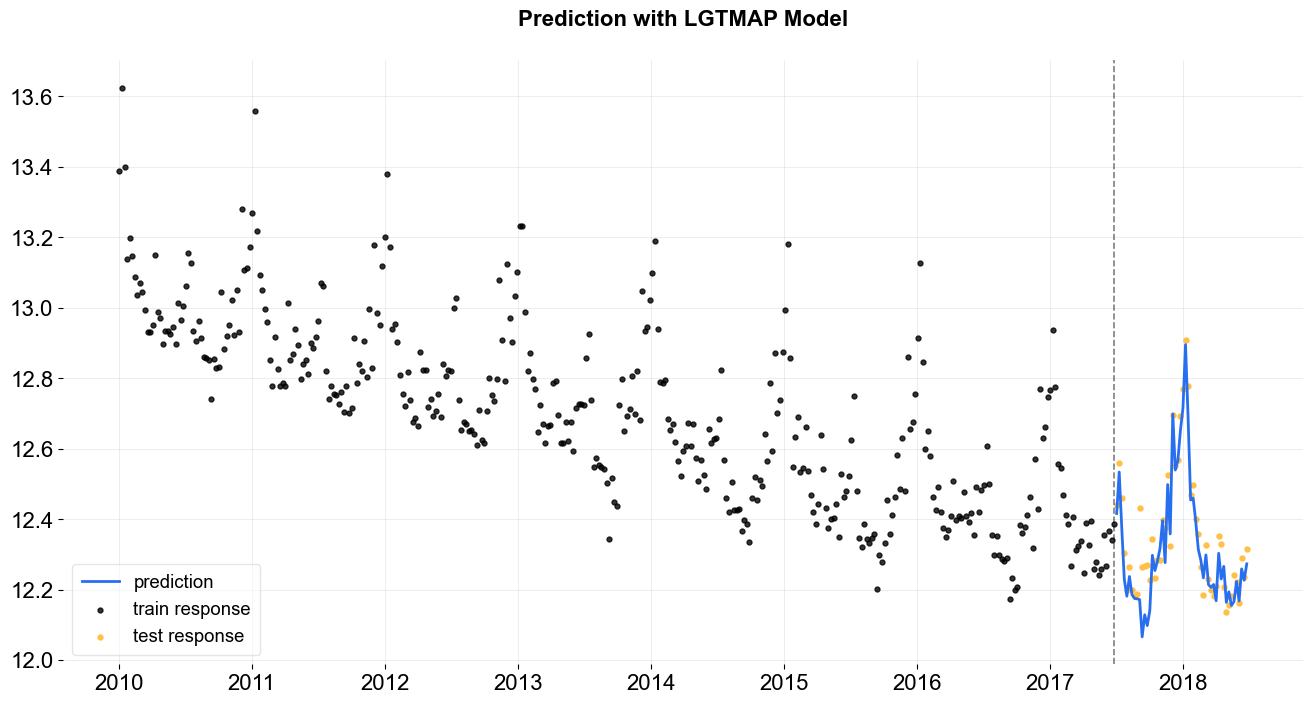

In [7]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with LGTMAP Model')

### LGT - MCMC

To use MCMC sampling, specify the estimator as `stan-mcmc` (the default). 

* By dedault, full Bayesian samples will be used for the predictions: for each set of parameter posterior samples, the prediction will be conducted once and the final predictions are aggregated over all the results. To be specific, the final predictions will be the median (aka 50th percentile) along with any additional percentiles provided. One can use `.get_posterior_samples()` to extract the samples for all sampling parameters.

* One can also specify `point_method` (either `mean` or `median`) via `.fit` to have the point estimate: the parameter posterior samples are aggregated first (mean or median) then conduct the prediction once.

#### LGT - full

In [8]:
lgt = LGT(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [9]:
%%time
lgt.fit(df=train_df)

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.000, warmups(per chain):225 and samples(per chain):25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 77.7 ms, sys: 63.6 ms, total: 141 ms
Wall time: 5.86 s


In [10]:
predicted_df = lgt.predict(df=test_df)

In [11]:
predicted_df.tail(5)

,week,prediction_5,prediction,prediction_95
47,2018-05-27,12.138702,12.236653,12.325029
48,2018-06-03,12.042856,12.164003,12.282972
49,2018-06-10,12.177416,12.271215,12.393355
50,2018-06-17,12.126099,12.228332,12.343101
51,2018-06-24,12.151659,12.278477,12.375120


In [12]:
lgt.get_posterior_samples().keys()

odict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lgt_sum', 'gt_pow', 'lt_coef', 'gt_coef', 's', 'sea_sm'])

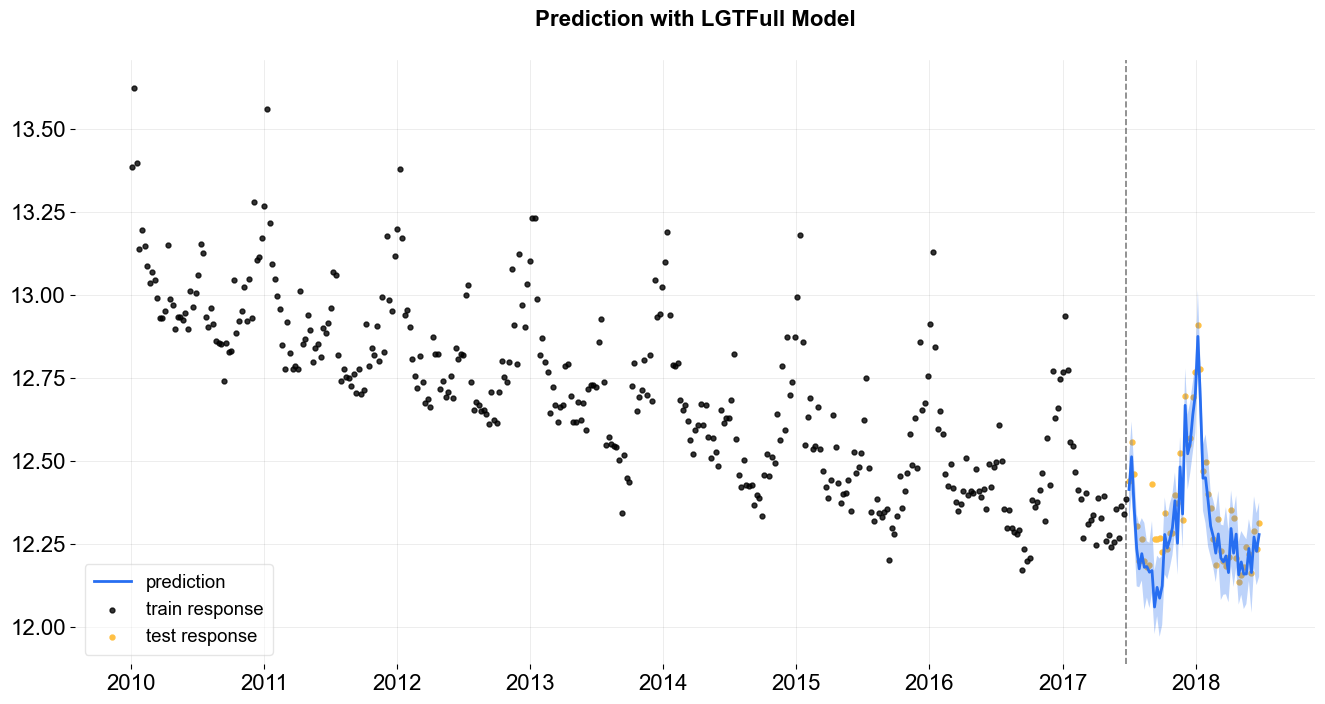

In [13]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, 
                    test_actual_df=test_df, title='Prediction with LGTFull Model')

#### LGT - point estimate

In [14]:
lgt = LGT(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [15]:
%%time
lgt.fit(df=train_df, point_method='mean')

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.000, warmups(per chain):225 and samples(per chain):25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 83 ms, sys: 71.9 ms, total: 155 ms
Wall time: 6.13 s


In [16]:
predicted_df = lgt.predict(df=test_df)

In [17]:
predicted_df.tail(5)

,week,prediction
47,2018-05-27,12.198260
48,2018-06-03,12.134447
49,2018-06-10,12.227925
50,2018-06-17,12.195388
51,2018-06-24,12.241482


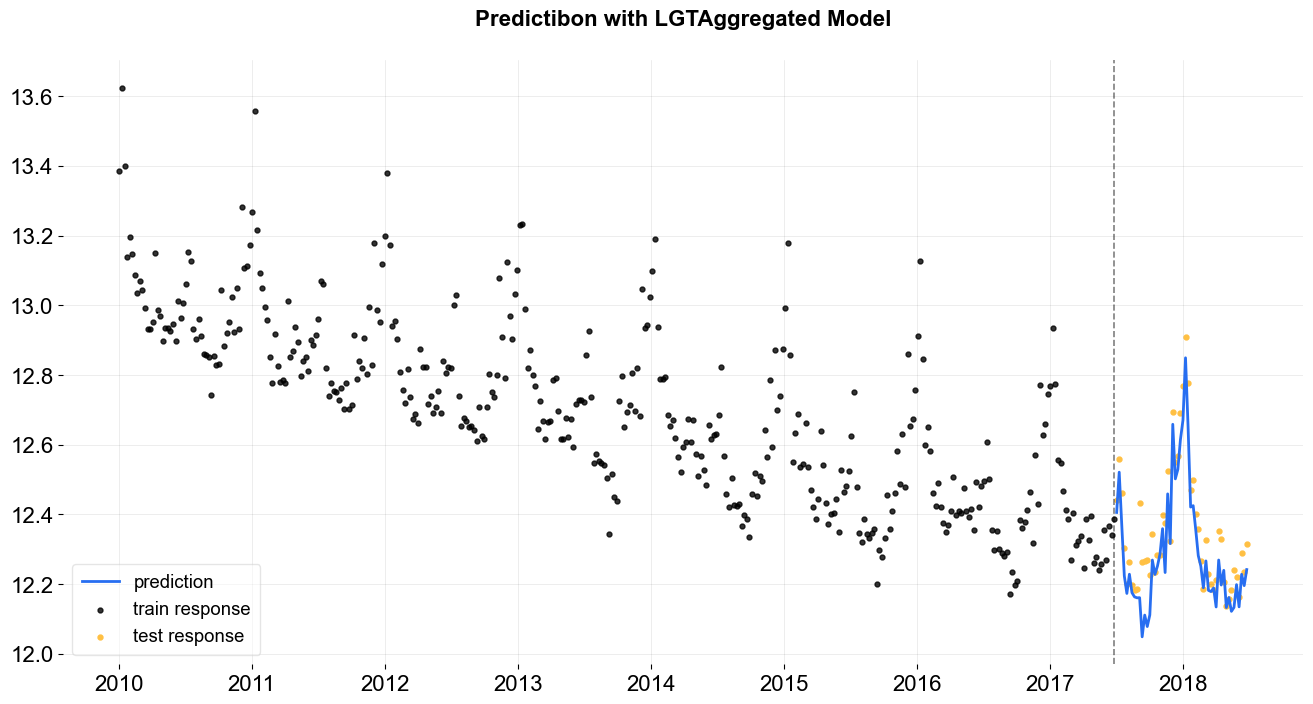

In [18]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, 
                    test_actual_df=test_df, title='Predictibon with LGTAggregated Model')